# **DEMO: Training face recognition model using facenet**

In [16]:
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from PIL import Image
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from os import listdir
from os.path import isdir
import cv2
import matplotlib.pyplot as plt
from numpy import expand_dims

from random import choice
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

from utils import extract_face, load_faces, load_dataset, get_embedding, preprocessing

import pickle

# Dataset pipeline

## Extract face

In [9]:
directory = 'images/train/Tony Stark/'
filename = '131d586829ca1ed761a2a40c1a6e6e50.jpg'

In [11]:
image = Image.open(directory + filename)
image = image.convert('RGB')
pixels = asarray(image)

detector = MTCNN()
results = detector.detect_faces(pixels)
x1, y1, width, height = results[0]['box']
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height
face = pixels[y1:y2, x1:x2]

required_size = (160,160)
image_ori = Image.fromarray(face)
image_resize = image_ori.resize(required_size)
face_array = asarray(image_resize)

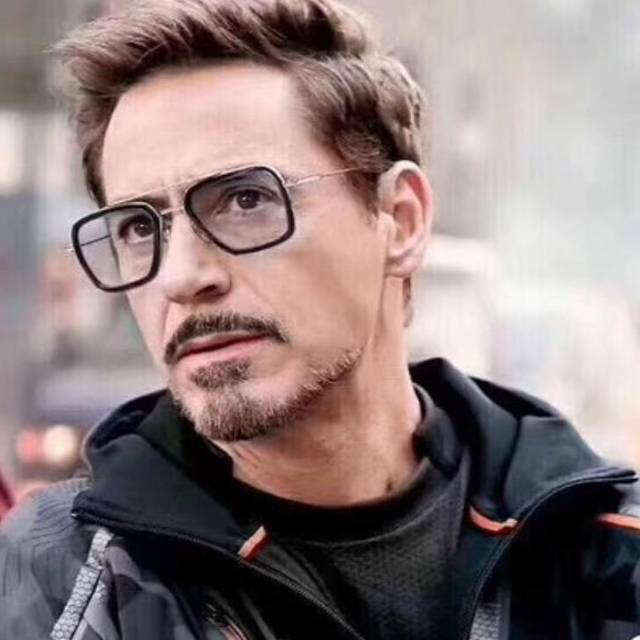

In [14]:
image

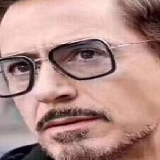

In [12]:
image_resize

## Load faces

In [25]:
directory = 'images/train/Tony Stark/'

In [26]:
faces = list()
for filename in listdir(directory):
    path = directory + filename
    face, image = extract_face(path)
    faces.append(face)

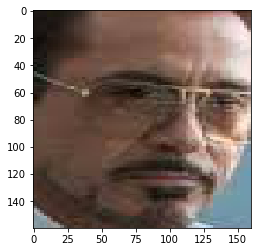

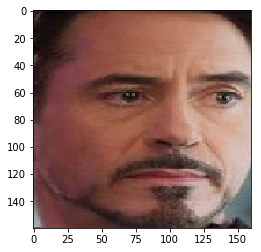

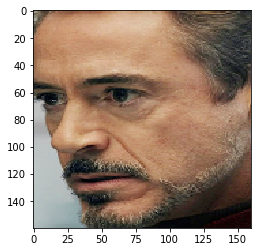

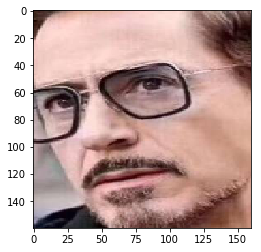

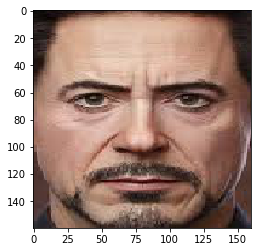

In [27]:
for face in faces:
    plt.imshow(face)
    plt.show()

## Load dataset

In [33]:
directory = 'images/train/'

In [38]:
X, y = list(), list()
for subdir in ['Tony Stark', 'Steve Rogers']:
    path = directory + subdir + '/'
    if not isdir(path):
        continue
    faces = load_faces(path)
    labels = [subdir for _ in range(len(faces))]
    print('>loaded %d examples for class: %s' % (len(faces), subdir))
    X.extend(faces)
    y.extend(labels)

>loaded 5 examples for class: Tony Stark
>loaded 5 examples for class: Steve Rogers


In [40]:
y

['Tony Stark',
 'Tony Stark',
 'Tony Stark',
 'Tony Stark',
 'Tony Stark',
 'Steve Rogers',
 'Steve Rogers',
 'Steve Rogers',
 'Steve Rogers',
 'Steve Rogers']

In [ ]:
for face in X:
    plt.imshow(face)
    plt.show()

## Preprocessing using facenet embedding

In [41]:
model_facenet = load_model('model/facenet_keras.h5')

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [42]:
X_prep = list()
for face_pixels in X:
    embedding = get_embedding(model_facenet, face_pixels)
    X_prep.append(embedding)
X_prep = asarray(X_prep)

in_encoder = Normalizer(norm='l2')
X_prep = in_encoder.transform(X_prep)

In [50]:
X_prep

array([[-0.05712675, -0.09784133,  0.17168432, ..., -0.04726762,
        -0.09278747,  0.07530012],
       [-0.08146346, -0.10518642,  0.08202162, ..., -0.08819328,
        -0.05858683,  0.05121176],
       [-0.06900179, -0.02521374,  0.00256328, ..., -0.12180544,
         0.03577152,  0.05833981],
       ...,
       [-0.01290393,  0.08806752, -0.10767903, ..., -0.17586817,
         0.02540555,  0.02282205],
       [-0.10711652,  0.1348762 , -0.03852135, ..., -0.08417113,
         0.17420079, -0.00345713],
       [-0.09895184,  0.07224052,  0.07271623, ..., -0.27808934,
         0.1617722 ,  0.00601987]], dtype=float32)

# Modeling

### Load train and test data

In [52]:
directory = 'images/train/'
X_train, y_train = load_dataset(directory)

>loaded 5 examples for class: Tony Stark
>loaded 5 examples for class: Steve Rogers
>loaded 5 examples for class: Thor


In [53]:
directory = 'images/test/'
X_test, y_test = load_dataset(directory)

>loaded 3 examples for class: Tony Stark
>loaded 3 examples for class: Steve Rogers
>loaded 3 examples for class: Thor


### Preprocess

In [55]:
X_train = preprocessing(X_train, model_facenet)
X_test = preprocessing(X_test, model_facenet)

In [58]:
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

### Train the model

In [59]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate the model using test dataset

In [60]:
y_predict_test = model.predict(X_test)

In [61]:
accuracy_score(y_test, y_predict_test)

1.0

### Predict selected picture

In [75]:
directory = 'images/test/Steve Rogers/'
filename = 'd896715b-9b72-46bd-89bf-c1a5681ca2b2_169.jpg'

/home/aryoerlangga/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


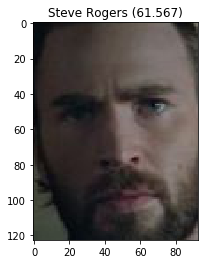

In [76]:
image = Image.open(directory + filename)
image = image.convert('RGB')
pixels = asarray(image)

detector = MTCNN()
results = detector.detect_faces(pixels)

x1, y1, width, height = results[0]['box']
x1, y1 = abs(x1), abs(y1)
x2, y2 = x1 + width, y1 + height
face = pixels[y1:y2, x1:x2]

image_ori = Image.fromarray(face)
image_resize = image_ori.resize((160,160))
face_array = asarray(image_resize)

face = asarray([face_array])

face = preprocessing(face, model_facenet) 

yhat_class = model.predict(face)
yhat_prob = model.predict_proba(face)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

plt.imshow(image_ori)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()